In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

class RareDiseaseFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None, n_way=2, k_shot=5, k_query=5):
        self.root_dir = root_dir
        self.transform = transform
        self.n_way = n_way
        self.k_shot = k_shot
        self.k_query = k_query
        self.image_files = {"Pink Disease": [], "Nematode": []}

        # Load images by class
        for class_name in self.image_files.keys():
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith(".jpg"):
                        # Get the label from the corresponding .txt file
                        label_file = file.replace(".jpg", ".txt")
                        label_path = os.path.join(class_path, label_file)
                        
                        # Read the label file
                        with open(label_path, "r") as f:
                            label = int(f.readline().split()[0])  # Get the class id
                        
                        self.image_files[class_name].append((os.path.join(class_path, file), label))

        # Ensure enough images for few-shot learning
        for class_name, images in self.image_files.items():
            if len(images) < k_shot + k_query:
                raise ValueError(f"Not enough samples in '{class_name}' for {k_shot}-shot learning!")

    def sample_task(self):
        """Samples an N-way K-shot learning task."""
        sampled_classes = random.sample(list(self.image_files.keys()), self.n_way)
        support_set, query_set, labels = [], [], []

        for label, class_name in enumerate(sampled_classes):
            class_images = random.sample(self.image_files[class_name], self.k_shot + self.k_query)
            support_set.extend([(img, label) for img, label in class_images[:self.k_shot]])
            query_set.extend([(img, label) for img, label in class_images[self.k_shot:]])

        return support_set, query_set

    def __getitem__(self, _):
        """Returns a single few-shot task."""
        support_set, query_set = self.sample_task()

        def load_images(image_list):
            images, labels = [], []
            for img_path, label in image_list:
                image = Image.open(img_path).convert("RGB")
                if self.transform:
                    image = self.transform(image)
                images.append(image)
                labels.append(label)
            return torch.stack(images), torch.tensor(labels)

        support_images, support_labels = load_images(support_set)
        query_images, query_labels = load_images(query_set)

        return support_images, support_labels, query_images, query_labels

    def __len__(self):
        return 1000  # Generate 1000 tasks

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset for few-shot learning
fewshot_dataset = RareDiseaseFewShotDataset("../data/rare_disease/", transform)
fewshot_dataloader = DataLoader(fewshot_dataset, batch_size=1, shuffle=True)

# Test dataset loading
for support_images, support_labels, query_images, query_labels in fewshot_dataloader:
    print(f"Support Set: {support_images.shape}, Labels: {support_labels}")
    print(f"Query Set: {query_images.shape}, Labels: {query_labels}")
    break

Support Set: torch.Size([1, 10, 3, 224, 224]), Labels: tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])
Query Set: torch.Size([1, 10, 3, 224, 224]), Labels: tensor([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ProtoNetWithResNet50(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ProtoNetWithResNet50, self).__init__()
        
        # Load pre-trained ResNet-50 model
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Remove the fully connected layer (the classifier) from ResNet-50
        self.feature_extractor = nn.Sequential(*list(resnet50.children())[:-1])
        
        # Add a new fully connected layer to map the feature to the embedding space
        self.fc = nn.Linear(resnet50.fc.in_features, embedding_dim)
    
    def forward(self, x):
        # Extract features from the image using the ResNet-50 backbone
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, feature_size)
        
        # Pass the features through the fully connected layer to get embeddings
        return self.fc(x)
    

def compute_prototypes(support_images, support_labels, model):
    """Computes class prototypes as mean embeddings."""
    unique_classes = support_labels.unique()
    prototypes = []
    for cls in unique_classes:
        class_indices = (support_labels == cls).nonzero(as_tuple=True)[0]
        class_embeddings = model(support_images[class_indices])  # Get embeddings
        prototypes.append(class_embeddings.mean(dim=0))  # Compute mean
    return torch.stack(prototypes)

def classify_query(prototypes, query_images, model):
    """Assigns query images to nearest prototype."""
    query_embeddings = model(query_images)  # Get embeddings for query images
    distances = torch.cdist(query_embeddings, prototypes)  # Compute Euclidean distance to prototypes
    return distances  # Return raw distance (logits for the cross-entropy loss)



🚀 Starting Experiment 1 | LR=0.001, Embedding=64
[Exp 1] Episode 0: Loss=0.692135, Accuracy=0.60
[Exp 1] Episode 10: Loss=0.335442, Accuracy=0.90
[Exp 1] Episode 20: Loss=1.058297, Accuracy=0.10
[Exp 1] Episode 30: Loss=0.135625, Accuracy=0.90
[Exp 1] Episode 40: Loss=0.016151, Accuracy=1.00
[Exp 1] Episode 50: Loss=0.007262, Accuracy=1.00
[Exp 1] Episode 60: Loss=0.001968, Accuracy=1.00
[Exp 1] Episode 70: Loss=0.000050, Accuracy=1.00
[Exp 1] Episode 80: Loss=0.001040, Accuracy=1.00
[Exp 1] Episode 90: Loss=0.000072, Accuracy=1.00
[Exp 1] Episode 100: Loss=0.000092, Accuracy=1.00
[Exp 1] Episode 110: Loss=0.000016, Accuracy=1.00
[Exp 1] Episode 120: Loss=0.002007, Accuracy=1.00
[Exp 1] Episode 130: Loss=0.000006, Accuracy=1.00
[Exp 1] Episode 140: Loss=0.000027, Accuracy=1.00
[Exp 1] Episode 150: Loss=0.000014, Accuracy=1.00
[Exp 1] Episode 160: Loss=0.000002, Accuracy=1.00
[Exp 1] Episode 170: Loss=0.000005, Accuracy=1.00
[Exp 1] Episode 180: Loss=0.000001, Accuracy=1.00
[Exp 1] Epis

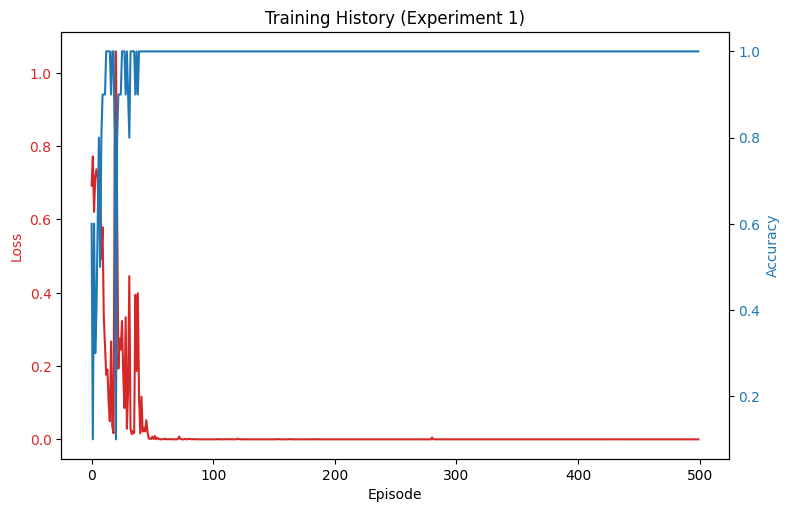

🚀 Starting Experiment 2 | LR=0.001, Embedding=128
[Exp 2] Episode 0: Loss=0.708874, Accuracy=0.20
[Exp 2] Episode 10: Loss=0.138713, Accuracy=1.00
[Exp 2] Episode 20: Loss=0.426073, Accuracy=0.90
[Exp 2] Episode 30: Loss=0.088550, Accuracy=1.00
[Exp 2] Episode 40: Loss=0.009462, Accuracy=1.00
[Exp 2] Episode 50: Loss=0.000580, Accuracy=1.00
[Exp 2] Episode 60: Loss=0.000064, Accuracy=1.00
[Exp 2] Episode 70: Loss=0.000233, Accuracy=1.00
[Exp 2] Episode 80: Loss=0.004539, Accuracy=1.00
[Exp 2] Episode 90: Loss=0.000523, Accuracy=1.00
[Exp 2] Episode 100: Loss=0.301954, Accuracy=0.90
[Exp 2] Episode 110: Loss=0.064254, Accuracy=1.00
[Exp 2] Episode 120: Loss=0.208861, Accuracy=1.00
[Exp 2] Episode 130: Loss=0.670396, Accuracy=0.90
[Exp 2] Episode 140: Loss=0.006740, Accuracy=1.00
[Exp 2] Episode 150: Loss=0.002328, Accuracy=1.00
[Exp 2] Episode 160: Loss=0.000125, Accuracy=1.00
[Exp 2] Episode 170: Loss=0.000002, Accuracy=1.00
[Exp 2] Episode 180: Loss=0.003537, Accuracy=1.00
[Exp 2] Epi

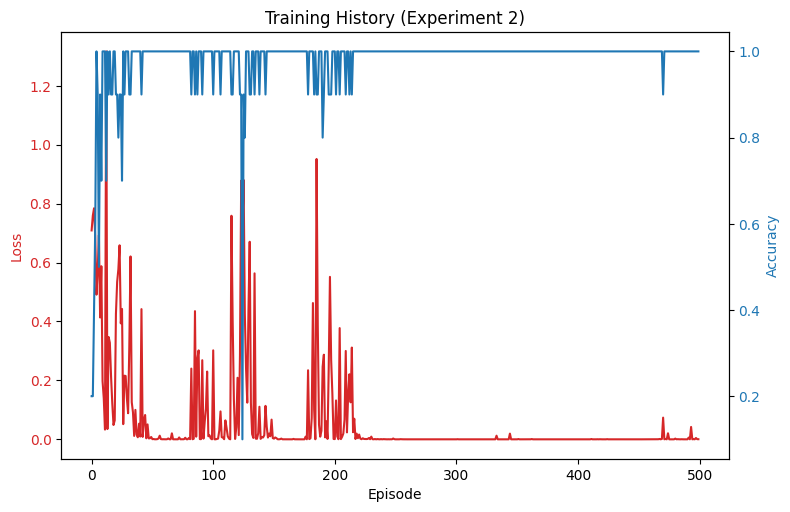

🚀 Starting Experiment 3 | LR=0.001, Embedding=256
[Exp 3] Episode 0: Loss=0.705322, Accuracy=0.50
[Exp 3] Episode 10: Loss=0.837503, Accuracy=0.00
[Exp 3] Episode 20: Loss=0.095976, Accuracy=1.00
[Exp 3] Episode 30: Loss=0.022799, Accuracy=1.00
[Exp 3] Episode 40: Loss=0.030066, Accuracy=1.00
[Exp 3] Episode 50: Loss=0.002138, Accuracy=1.00
[Exp 3] Episode 60: Loss=0.001528, Accuracy=1.00
[Exp 3] Episode 70: Loss=0.000037, Accuracy=1.00
[Exp 3] Episode 80: Loss=0.437604, Accuracy=0.80
[Exp 3] Episode 90: Loss=0.629259, Accuracy=0.80
[Exp 3] Episode 100: Loss=0.634214, Accuracy=0.80
[Exp 3] Episode 110: Loss=0.090897, Accuracy=1.00
[Exp 3] Episode 120: Loss=0.010073, Accuracy=1.00
[Exp 3] Episode 130: Loss=0.474237, Accuracy=0.90
[Exp 3] Episode 140: Loss=0.001583, Accuracy=1.00
[Exp 3] Episode 150: Loss=0.024935, Accuracy=1.00
[Exp 3] Episode 160: Loss=0.000467, Accuracy=1.00
[Exp 3] Episode 170: Loss=0.013483, Accuracy=1.00
[Exp 3] Episode 180: Loss=0.014213, Accuracy=1.00
[Exp 3] Epi

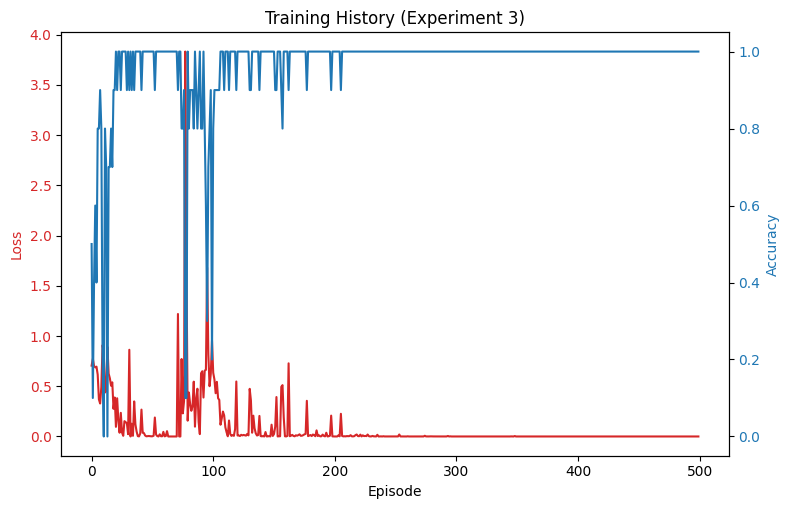

✅ All experiments completed! Results saved in 'results.csv'.


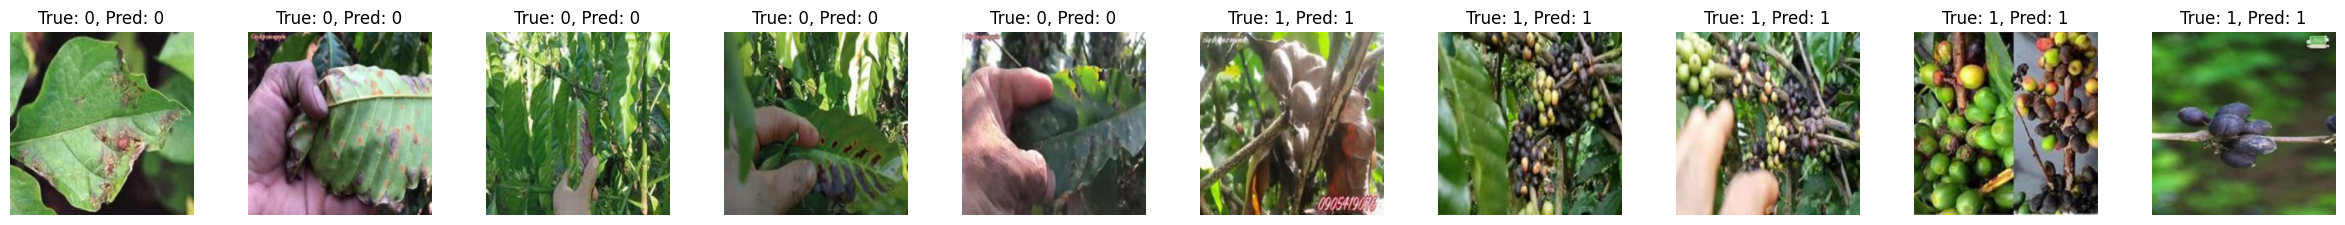

In [3]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

# Define different hyperparameter settings
experiments = [
    {"lr": 0.001, "embedding_dim": 64, "num_episodes": 500},
    {"lr": 0.001, "embedding_dim": 128, "num_episodes": 500},
    {"lr": 0.001, "embedding_dim": 256, "num_episodes": 500},
]

# CSV file path
csv_filename = "results.csv"

# Initialize CSV file with headers if not exists
if not os.path.exists(csv_filename):
    pd.DataFrame(columns=["Experiment", "Episode", "Loss", "Accuracy"]).to_csv(csv_filename, index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to plot accuracy & loss history
def plot_training_history(history, experiment_id):
    """Plots training loss & accuracy for a given experiment."""
    episodes = [x["Episode"] for x in history]
    losses = [x["Loss"] for x in history]
    accuracies = [x["Accuracy"] for x in history]

    fig, ax1 = plt.subplots(figsize=(8, 5))

    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(episodes, losses, label="Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(episodes, accuracies, label="Accuracy", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    plt.title(f"Training History (Experiment {experiment_id})")
    plt.show()

# Run each experiment
for exp_num, exp in enumerate(experiments):
    print(f"🚀 Starting Experiment {exp_num+1} | LR={exp['lr']}, Embedding={exp['embedding_dim']}")

    # Initialize model and optimizer
    model = ProtoNetWithResNet50(embedding_dim=exp["embedding_dim"]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=exp["lr"])
    num_episodes = exp["num_episodes"]
    
    history = []  # Store results for plotting
    results = []  # Store results for CSV saving

    for episode in range(num_episodes):
        support_images, support_labels, query_images, query_labels = next(iter(fewshot_dataloader))

        # Move data to device
        support_images, support_labels = support_images.squeeze(0).to(device), support_labels.squeeze(0).to(device)
        query_images, query_labels = query_images.squeeze(0).to(device), query_labels.squeeze(0).to(device)

        # Compute prototypes
        prototypes = compute_prototypes(support_images, support_labels, model)

        # Classify query images
        predictions = classify_query(prototypes, query_images, model)

        # Compute loss
        loss = F.cross_entropy(predictions, query_labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted_classes = torch.argmax(predictions, dim=1)
        acc = (predicted_classes == query_labels).float().mean().item()

        # Store results
        history.append({"Episode": episode, "Loss": loss.item(), "Accuracy": acc})

        # Print every 10 episodes
        if episode % 10 == 0:
            print(f"[Exp {exp_num+1}] Episode {episode}: Loss={loss.item():.6f}, Accuracy={acc:.2f}")
            results.append({"Experiment": exp_num+1, "Episode": episode, "Loss": loss.item(), "Accuracy": acc})

    # Save results every 10 episodes
    df = pd.DataFrame(results)
    df.to_csv(csv_filename, mode="a", header=False, index=False)

    # Plot accuracy & loss history
    plot_training_history(history, exp_num+1)

print("✅ All experiments completed! Results saved in 'results.csv'.")

# 🔹 Visualization Function (for last trained model)
def visualize_predictions(support_images, support_labels, query_images, query_labels, predictions):
    """Visualizes a batch of query images with predicted & true labels."""
    query_images = query_images.cpu().numpy()
    predicted_classes = torch.argmax(predictions, dim=1)

    num_images = len(query_images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 5))  

    if num_images == 1:
        axes = [axes]

    for i in range(num_images):
        actual_label = query_labels[i].item()
        predicted_label = predicted_classes[i].item()

        image = query_images[i].transpose(1, 2, 0)  
        image = np.clip(image, 0, 1)

        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"True: {actual_label}, Pred: {predicted_label}")

    plt.subplots_adjust(wspace=0.3)
    plt.show()

# Example usage (after training)
visualize_predictions(support_images, support_labels, query_images, query_labels, predictions)